# SVV -Group 13

In [205]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib notebook

## Cross Section Estimation

Adding Input parameters for A320

In [258]:
#-------------------------------------------------------------------------
# Input paramters aileron
#-------------------------------------------------------------------------

# A320 INPUT VALUES FOR VALIDATION

Ca = 0.547              #chord length aileron [m]
la = 2.771              #span of the aileron [m]
x1 = 0.153               #x-location of hing 1 [m]
x2 = 1.281               #x-location of hing 2 [m]
x3 = 2.681               #x-location of hing 3 [m]
xa = 0.28               #distance between actuator 1 and 2 [m]
xa1 = x2-x_a/2
xa2 = x2+x_a/2
h = 0.225/2              #aileron height [m]
tsk = 0.0011            #skin thickness [m]
tsp = 0.0029            #spar thickness [m]
tst = 0.0012            #stiffener thickness [m]
hst = 0.015             #heigt of stiffener [m]
wst = 0.020             #width of stiffener [m]
nst = 17                #number of stiffeners equally spaced [-]
d1 = 0.01103             #vertical displacement hinge 1
d3 = 0.01642             #vertical displacement hinge 3
theta = np.radians(26)   #maximum upward deflection
P = 91700                #load in actuator 2

# A320 INPUT VALUES FOR VERIFICATION (VALUES TAKEN FROM THE MODEL AND IMPORTED)

"""Ca = 0.605  # m
la = 2.661  # m
x1 = 0.172  # m
x2 = 1.211  # m
x3 = 2.591  # m
xa = 0.35   # m
xa1 = x2-x_a/2
xa2 = x2+x_a/2
h = 0.205  # m
tsk = 1.1/1000  # m
tsp = 2.8/1000  # m
tst = 1.2/1000  # m
hst = 16./1000   # m
wst = 19./1000   # m
nst = 15  # -
d1 = 0.01154  # m
d3 = 0.01840  # m
theta = np.radians(28)  # rad
P = 97.4*1000  # N
N = 20     # Number of basis functions to use in Rayleigh-Ritz method (total number of coefficients is 3*N)
E = 73.1*10**9       # E-modulus (Pa)
G = 28*10**9       # G-modulus (Pa)"""

# always active inputs
path = 'load_A320.dat'
stepsize = 0.01
E = 73.1e9
G = 28e9
steps = 100

# input adaptation
C_a = Ca
l_a = la
x_a = xa

Specifying geometrical information

In [259]:
def Stiffener_spacing(h,C_a):
    perimeter_semicircle = np.pi*h
    perimeter_triangle = 2*np.sqrt((C_a-h)**2+h**2)
    stiffener_spacing_semicircle = perimeter_semicircle/6
    stiffener_spacing_triangle = perimeter_triangle/14
    return stiffener_spacing_triangle, stiffener_spacing_semicircle, perimeter_semicircle,perimeter_triangle       #[m]

def Stiffener_locations(h,C_a,stiffener_spacing_semicircle):
    y_lst = []
    z_lst = []

    for i in range(3):
        theta = np.radians(i * stiffener_spacing_semicircle/(np.pi*h)*180)
        delta_y = h*np.sin(theta)
        delta_z = h-h*np.cos(theta)
        y_lst.append(delta_y)
        z_lst.append(-delta_z)
        
    for i in range(1,7):
        y = h - i*h/7
        z = -h-i*(C_a-h)/7
        y_lst.append(y)
        z_lst.append(z)
        
    reverse_z = z_lst[::-1]
    reverse_y = y_lst[::-1]
    
    for i in range(len(reverse_z)-1):
        z_lst.append(reverse_z[i])
        y_lst.append(-reverse_y[i])
        
    return (z_lst, y_lst)

def Stiffener_A(w_st,h_st,t_st):
    A_st = w_st*t_st+(h_st-t_st)*t_st
    return A_st

def Centroid(z_lst,A_st,C_a,t_sk,t_sp,h):
    
    yc=0
    stff = sum([i * A_st for i in z_lst])
    triangle = -2*(h+(C_a-h)/2)*np.sqrt((C_a-h)**2+h**2)*t_sk
    semic =  -h*(1-2/np.pi)*np.pi*2*h*t_sk/2
    spar=-t_sp*h*2*h

    zc=(stff+semic+triangle+spar)/(17*A_st+np.sqrt((C_a-h)**2+h**2)*t_sk*2+np.pi*2*h*t_sk/2+t_sp*2*h)
    
    return (yc, zc)

def MMI(z_lst,y_lst,A_st,C_a,t_sk,t_sp,h,zc,yc):
    incl = np.sqrt((C_a - h) ** 2 + h ** 2)

    stff_z= sum([(i - yc) ** 2 * A_st for i in y_lst])
    triangle_z = ((2*incl)**3*t_sk/12)*((h)/incl)**2
    spar_z = (2*t_sp/12)*(2*h)**3
    semic_z = 0.5*np.pi*h**3*t_sk/8
    Izz= stff_z+triangle_z+spar_z+semic_z

    stff_y = sum([(i - zc) ** 2 * A_st for i in z_lst])
    triangle_y = 2 / 12 * t_sk * (incl) ** 3 * ((C_a - h) / incl) ** 2 + 2 * incl * t_sk * (-h - (C_a - h) / 2 - zc) ** 2
    spar_y = (2 * h / 12) * (t_sk) ** 3 + 2 * h * t_sp * (-h - zc) ** 2
    semic_y = h ** 3 * t_sk * (np.pi / 2 - 4 / np.pi) + np.pi * h * t_sk * ((-h + 2 * h / np.pi) - zc) ** 2

    Iyy= stff_y + spar_y + semic_y +triangle_y

    return Izz,Iyy

def integrate(a,b,n,fx): #enter funtion in the form lamda x:f(x)

    f =  fx
    h = (b-a)/n
    A = 0.5*h*(f(a)+f(b))
    for i in range(1,n):
        A += h*(f(a+i*h))
    return A

def shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,segment,b,Sy,Sz,n,incl):  #see diagram on paper

    qbl=[]
    qb1t = (-Sy / Izz) * (integrate(0, 0.5 * np.pi, 100, lambda x: h ** 2 * t_sk * np.sin(x)) + sum([A_st * i for i in (y_lst[0:3])]))+\
        (-Sz / Iyy) * (integrate(0, 0.5 * np.pi, 100, lambda x: (h-h*np.cos(x)-zc)*h*t_sk) + sum([A_st * (i-zc) for i in (z_lst[0:3])]))
    qb2t = (-Sy / Izz) * (integrate(0, h, 100, lambda x: t_sp * x)) + (-Sz / Iyy) * (integrate(0, h, 100, lambda x: t_sp * (-h-zc)))
    qb3t = (-Sy / Izz) * (integrate(0, incl, 100, lambda x: (h - (h / incl) * x)*t_sk) + sum( [A_st * i for i in (y_lst[3:9])])) + qb1t + qb2t +\
        (-Sz / Iyy) * (integrate(0, incl, 100, lambda x: (-h-((C_a-h)/incl)*x-zc)*t_sk) + sum( [A_st * (i-zc) for i in (z_lst[3:9])]))
    qb4t = (-Sy / Izz) * (integrate(0, incl, 100, lambda x: (- (h / incl) * x)*t_sk)+ sum([A_st * i for i in (y_lst[9:15])])) + qb3t +\
        (-Sz / Iyy) * (integrate(0, incl, 100, lambda x: (-C_a+((C_a-h)/incl)*x-zc)*t_sk)+ sum([A_st * (i-zc) for i in (z_lst[9:15])]))
    qb5t = (-Sy / Izz) * (integrate(0, -h, 100, lambda x: t_sp * x)) + (-Sz / Iyy) * (integrate(0, -h, 100, lambda x: t_sp * (-h-zc)))

    h_seg=b/((len(segment)*n)-1)

    ds=0
    
    for segment in segment:
        for i in range(n):
            b=h_seg*(i+ds)
            # upper part semi circle
            if segment <=2:
                      qb=(-Sy/Izz)*(integrate(0,b,100, lambda x:h**2*t_sk*np.sin(x))+sum([A_st*i for i in (y_lst[0:segment+1])]))+\
                         (-Sz / Iyy) * (integrate(0,b, 100, lambda x: (h-h*np.cos(x)-zc)*h*t_sk) + sum([A_st * (i-zc) for i in (z_lst[0:segment+1])]))
            # upper spar part
            elif segment ==3:
                      qb = (-Sy / Izz) * (integrate(0, b, 100, lambda x: t_sp * x )) + (-Sz / Iyy) * (integrate(0, b, 100, lambda x: t_sp * (-h-zc)))
            # upper triangular part
            elif 4<=segment<=10:
                if segment == 4:
                      qb = (-Sy / Izz) * (integrate(0, b, 100, lambda x: (h - (h / incl) * x)*t_sk)) + qb1t + qb2t +\
                           (-Sz / Iyy) * (integrate(0, b, 100, lambda x: ((-h-((C_a-h)/incl)*x)-zc)*t_sk))
                else:
                      qb = (-Sy / Izz) * (integrate(0, b, 100, lambda x: (h - (h / incl) * x)*t_sk) + sum([A_st * i for i in (y_lst[3:segment-1])])) + qb1t + qb2t +\
                           (-Sz / Iyy) * (integrate(0, b, 100, lambda x: ((-h-((C_a-h)/incl)*x)-zc)*t_sk) + sum([A_st * (i-zc) for i in (z_lst[3:segment-1])]))
            # lower triangular part
            elif 11<=segment<=17:
                if segment ==11:
                      qb = (-Sy / Izz) * (integrate(0, b, 100, lambda x: - (h / incl) * x*t_sk)) + qb3t +\
                           (-Sz / Iyy) * (integrate(0, b, 100, lambda x: ((-C_a+((C_a-h)/incl)*x)-zc)*t_sk))
                else:
                      qb = (-Sy / Izz) * (integrate(0, b, 100, lambda x: - (h / incl) * x*t_sk) + sum([A_st * i for i in (y_lst[9:segment-2])])) + qb3t +\
                           (-Sz / Iyy) * (integrate(0, b, 100, lambda x: ((-C_a+((C_a-h)/incl)*x)-zc)*t_sk)+ sum([A_st * (i-zc) for i in (z_lst[9:segment-2])]))
            # lower spar part
            elif segment == 18:
                      qb   = (-Sy / Izz) * (integrate(0, -b, 100, lambda x: t_sp * x)) + (-Sz / Iyy) * (integrate(0, -b, 100, lambda x: t_sp * (-h-zc)))
            # lower part semi circle
            else:
                b=-0.5*np.pi+b
                if segment==19:
                      qb  = (-Sy / Izz) * (integrate(-0.5*np.pi,b, 100, lambda x: h ** 2 * t_sk * np.sin(x)) ) + qb4t -qb5t +\
                            (-Sz / Iyy) * (integrate(-0.5*np.pi,b, 100, lambda x: ((h-h*np.cos(x))-zc)*h*t_sk  ))
                else:
                      qb = (-Sy / Izz) * (integrate(-0.5*np.pi,b, 100, lambda x: h ** 2 * t_sk * np.sin(x)) + sum([A_st * i for i in (y_lst[15:segment-4])])) + qb4t - qb5t +\
                           (-Sz / Iyy) * (integrate(-0.5*np.pi,b, 100, lambda x: ((h-h*np.cos(x))-zc)*h*t_sk)+sum([A_st * (i-zc) for i in (z_lst[15:segment-4])]))
            qbl.append(qb)
        ds+=n
        
    return qbl

def second_integration(z_lst,q_lst):            #integration over number of points with known value,, approximated by trapezoidal rule, do for each wall!
                                                #q_lst is the shear flow of a number of points at a specific wall,
    step= z_lst[1] - z_lst[0]
    A = 0.5 * step * (q_lst[0] + q_lst[-1])
    for i in range(1,len(z_lst)):
        A += step*(q_lst[i])
    return A

def second_int(zlist,qblist):
    A=0
    for i,j in zip(zlist,qblist):
        A+=second_integration(i,j)
    return A

# add constant shearflow
def Add_constant_shearflow(qb1,qb2,qb3,qb4,qb5,qb6,qs01,qs02):
    qb1 = [i + qs01 for i in qb1]
    qb6 = [i + qs01 for i in qb6]
    qb2 = [i - qs01 + qs02 for i in qb2]
    qb5 = [i - qs01 + qs02 for i in qb5]
    qb4 = [i + qs02 for i in qb4]
    qb3 = [i + qs02 for i in qb3]
    return qb1,qb2,qb3,qb4,qb5,qb6

def Cell_area(h,C_a):
    A1 = np.pi*h**2/2
    A2 = h*(C_a-h)
    return A1, A2   #m^2
A1,A2=Cell_area(h,C_a)



Set input parameters and retreive plots

In [260]:
# define some new info

delta_st_triangle, delta_st_semicircle,per_semicircle,per_triangle = Stiffener_spacing(h,C_a)          # [m]
z_lst, y_lst = Stiffener_locations(h,C_a,delta_st_semicircle)     # [m]
A_st = Stiffener_A(w_st,h_st,t_st)
yc, zc = Centroid(z_lst,A_st,C_a,t_sk,t_sp,h)
Izz, Iyy = MMI(z_lst,y_lst,A_st,C_a,t_sk,t_sp,h,zc,yc)

incl = np.sqrt((C_a - h) ** 2 + h ** 2)

n1=20

#Sy=int(input("Is Sy 1 or 0?"))
#Sz=int(input("Is Sz 1 or 0?"))
Sz= 0
Sy= 1

qb1 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[0,1,2],0.5*np.pi,Sy,Sz,n1,incl)
qb2 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[3],h,Sy,Sz,2*n1,incl)
qb3 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[4,5,6,7,8,9,10],incl,Sy,Sz,n1,incl)
qb4 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[11,12,13,14,15,16,17],incl,Sy,Sz,n1,incl)
qb5 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[18],h,Sy,Sz,2*n1,incl)
qb6 = shearfl(Iyy,Izz,A_st,y_lst,z_lst,zc,h,t_sk,C_a,[19,20,21],0.5*np.pi,Sy,Sz,n1,incl)


# points along line of integration (s)
s_co1 = np.linspace(0,np.pi*h/2,3*n1)
s_co2 = np.linspace(0,h,2*n1)
s_co3 = np.linspace(0,incl,7*n1)
s_co4 = s_co3
s_co5 = s_co2
s_co6 = s_co1

qblist1 =[[i/t_sk for i in qb1],[-i/t_sp for i in qb2],[-i/t_sp for i in qb5],[i/t_sk for i in qb6]]
zlist1  =[s_co1,s_co2,s_co5,s_co6]

qblist2= [[i/t_sp for i in qb2],[i/t_sp for i in qb5],[i/t_sk for i in qb3],[i/t_sk for i in qb4]]
zlist2= [s_co2,s_co5,s_co3,s_co4]

a3=second_int(zlist1,qblist1)
b3=second_int(zlist2,qblist2)
a1= np.pi*h/t_sk + 2*h/t_sp
a2= -2*h/t_sp
b1= -2*h/t_sp
b2= 2*(incl/t_sk) + 2*h/t_sp

A = np.array([[a1,a2],[b1,b2]])
g = np.array([-a3,-b3])
solution = np.linalg.solve(A,g)

qs01 = solution[0]
qs02 = solution[1]

qb1,qb2,qb3,qb4,qb5,qb6=Add_constant_shearflow(qb1,qb2,qb3,qb4,qb5,qb6,qs01,qs02)

M2 =  ((C_a-h) / incl)*h*second_integration(s_co3,qb3) + ((C_a-h) / 
        incl)*h*second_integration(s_co4,qb4) + 2*h*second_integration(s_co1,qb1)

shear_center = -h-M2

# PRINT CROSS SECTION INFORMATION

if (Sy==1 and Sz==0):
     print(f"Shear center location from the leading edge: {shear_center}")

print(f"Constant shear flow 1: {qs01}")
print(f"Constant shear flow 2: {qs02}")
print(f"Area of the stiffener: {A_st} [m^2]")
print(f"Centroid Location: {yc, zc} [m] from the leading edge")
print(f"Moment of intertia around z: {Izz}")
print(f"Moment of intertia around y: {Iyy}")
print(f"Cell area 1: {A1}")
print(f"Cell area 2: {A2}")

Shear center location from the leading edge: -0.11718163941053941
Constant shear flow 1: 1.3420235677257826
Constant shear flow 2: 4.823760016222179
Area of the stiffener: 4.055999999999999e-05 [m^2]
Centroid Location: (0, -0.2138107044454049) [m] from the leading edge
Moment of intertia around z: 1.2912034805491943e-05
Moment of intertia around y: 6.668090917475084e-05
Cell area 1: 0.01988039101099791
Cell area 2: 0.04888125000000001


<IPython.core.display.Javascript object>


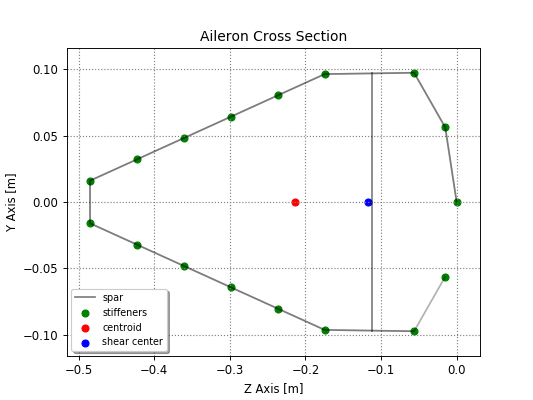

In [263]:
# PRINT CROSS SECTION

x_axis = z_lst
y_axis = y_lst
centroid = zc
shear_center = shear_center

plt.figure()

plt.title("Aileron Cross Section")
    
plt.scatter(x_axis, y_axis, color='g', label='stiffeners')
plt.scatter(centroid, 0, color='r', label='centroid')
plt.scatter(shear_center, 0, color='b', label='shear center')
plt.plot([-h, -h], [h-0.015, -h+0.015], color='k', alpha=0.5, label='spar')
plt.plot(x_axis, y_axis, color='k', alpha=0.3)
plt.plot(x_axis[0:-1], y_axis[0:-1], color='k', alpha=0.3)

plt.xlabel("Z Axis [m]")
plt.ylabel("Y Axis [m]")
plt.grid(linestyle='dotted')

legend = plt.legend(loc='lower left', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('white')

plt.show()

## Aerodynamic Load Discretization

In [210]:
class AeroLoad:
    """ the class gets a .dat file and plots the distribution, plus other info """

    def __init__(self, l_a, C_a, path):
        self.span = l_a
        self.chord = C_a
        self.file = path

    def get_mat(self):

        mat = np.zeros((81, 41))

        with open(self.file) as f:
            row = 0
            for line in f:
                values = line.split(",")
                values = [float(i) for i in values]
                mat[row, :] = values
                row += 1

        return mat

    def get_shape(self):
        return self.get_mat().shape[0], self.get_mat().shape[1]

    def get_coord(self):
        Ca = self.chord
        la = self.span

        N_z, N_x = self.get_shape()

        theta_z = np.arange(N_z + 1) * (np.pi / N_z)
        theta_x = np.arange(N_x + 1) * (np.pi / N_x)

        z_coord = np.zeros(N_z)
        x_coord = np.zeros(N_x)

        def get_linspace(theta, theta_1, seg):
            coord = -0.5 * ((seg / 2) * (1 - np.cos(theta)) + (seg / 2) * (1 - np.cos(theta_1)))
            return coord

        for i in range(N_z):
            z_coord[i] = get_linspace(theta_z[i], theta_z[i + 1], Ca)

        for i in range(N_x):
            x_coord[i] = get_linspace(theta_x[i], theta_x[i + 1], la)

        return z_coord, x_coord

    def get_discrete_distribution(self):
        mat = self.get_mat()

        coord = self.get_coord()

        q_x = []

        def get_resultant(row, spacing):
            resultant = 0

            for i in range(len(spacing)-1):
                r_i = (row[i] + row[i+1])*(spacing[i+1] - spacing[i])*0.5
                resultant += r_i

            return resultant

        for section in range(mat.shape[1]):
            q_x.append(get_resultant(mat[:, section], coord[0]))

        return q_x

    def get_q(self, x):

        disc = self.get_discrete_distribution()
        span = self.get_coord()[1]

        # find x location
        i = 0
        while x < span[i] and i < len(span) - 2:
            i += 1

        # get local linear relationship
        a = span[i]
        b = span[i+1]
        f_a = disc[i]
        f_b = disc[i+1]
        slope = (f_a-f_b)/(a-b)

        # get precise value
        value = (f_a + slope*(x-a))*1000

        return value

<IPython.core.display.Javascript object>


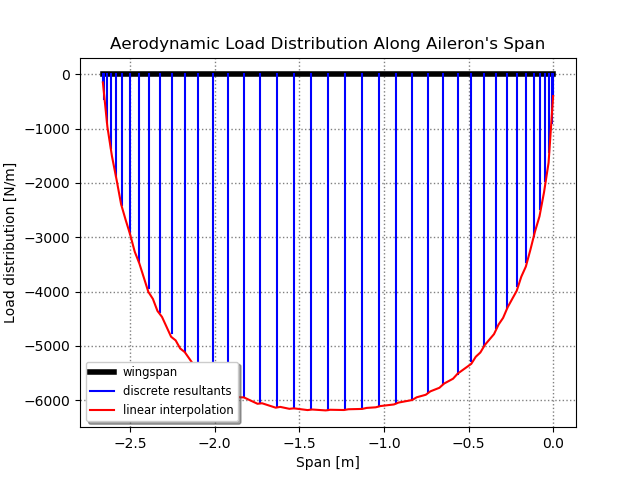

Getting linear distribution: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 105.98it/s]


In [211]:
# PLOT AERODYNAMIC LOAD

init_aero = AeroLoad(l_a, C_a, path)

q_x = init_aero.get_discrete_distribution()
coord = init_aero.get_coord()[1]

plt.figure()
plt.title(f"Aerodynamic Load Distribution Along Aileron's Span")

# plot span
plt.plot([0, -l_a], [0, 0], color='k', label='wingspan', linewidth=4)

# plot discrete distribution
for i in tqdm(range(len(q_x)), desc="Getting discrete distribution"):
    plt.plot([coord[i], coord[i]], [0, q_x[i]*1000], color='b')
plt.plot(0, 0, color='b', label='discrete resultants')

# plot distribution with linear interpolation
big_span = np.linspace(coord[0], coord[-1], 100)
big_res = [init_aero.get_q(x) for x in tqdm(big_span, desc="Getting linear distribution")]
plt.plot(big_span, big_res, color='r', label='linear interpolation')

# plot legend and labels
plt.xlabel("Span [m]")
plt.ylabel("Load distribution [N/m]")
plt.grid(linestyle='dotted')
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.show()

The get_discrete_xxxx functions make discrete functions for the respective xxxxx feature.
The xxxxx_resultants use these discrete functions/arrays then to derrive the approximated value at an exact input 
location. 

NOTE: The input of the get_discrete_xxx functions should always be the total length of the aileron, i.e. length 
aileron (la)

In [212]:
def trapezoidal_rule(row, step):
    """ Just trapezoidal rule between set of points"""
    resultant = 0
    for i in range(len(row)-1):
        r_i = (row[i-1] + row[i])*step*0.5
        resultant += r_i
    return resultant

# --------------- Discrete Load -----------------------

def get_discrete_load(x, cont_load, step):
    """ Given a continous load function q(x), this will make an array of the load at different
    locations with a set interval. For the trapezoidal rule"""
    discrete_load = np.empty_like(np.arange(0, x+step, step))
    for i in np.arange(0, x+step, step):
        discrete_load[int(round(i/step))] = cont_load.get_q(-i)
    return discrete_load

# --------------- Discrete resultant -----------------------

def get_discrete_resultant(la, discrete_load, step):
    """ Make discrete resultant function """
    discrete_resultant = np.zeros_like(np.arange(0, la+step, step))
    for i in np.arange(step, la+step, step):
        discrete_resultant[int(round(i/step))] = trapezoidal_rule(discrete_load[0:int(i/step)+1], step)
    return discrete_resultant

def magnitude_resultant(x, discrete_resultant, step):
    """ Finds resultant force of distribution from 0 till x_end according to given span distr.
        First it takes points from that distr and then uses trapezoidal rule. """
    if int((x+step)/step) >= len(discrete_resultant):
        return discrete_resultant[int(x/step)]
    return 0.5*(discrete_resultant[int((x+step)/step)]+discrete_resultant[int(x/step)])

# --------------- Discrete locations -----------------------

def get_discrete_location_resultant(la, discrete_resultant, discrete_load, step):
    """ Finds location of application resultant force. With formula:
            xbar  = integral(x*q(x))/integral(q(x)) """
    discrete_location = np.zeros_like(np.arange(0, la+step, step))
    discrete_resultant_x = discrete_load*np.arange(0, la+step, step)
    for i in np.arange(step, la, step):
        discrete_location[int(round(i/step))] = trapezoidal_rule(discrete_resultant_x[1:int(round(i/step))+2], step) / magnitude_resultant(i, discrete_resultant, step)
    return discrete_location

def location_resultant(x, discrete_location, step):
    """ Finds resultant force of distribution from 0 till x_end according to given span distr.
        First it takes points from that distr and then uses trapezoidal rule. """
    if int((x+step)/step) >= len(discrete_location):
        return discrete_location[int(x/step)]
    return 0.5*(discrete_location[int((x+step)/step)]+discrete_location[int(x/step)])

# --------------- Discrete moments -----------------------

def get_discrete_moment(discrete_resultant, discrete_location):
    """ Finds moment with respect to end point """
    return discrete_resultant*discrete_location

def moment_resultant(x, discrete_moment, step):
    """ Finds resultant force of distribution from 0 till x_end according to given span distr.
        First it takes points from that distr and then uses trapezoidal rule. """
    if int((x+step)/step) >= len(discrete_moment):
        return discrete_moment[int(x/step)]
    return 0.5*(discrete_moment[int((x+step)/step)]+discrete_moment[int(x/step)])

# --------------- Discrete angles -----------------------

def get_discrete_angle(la, discrete_moment, step):
    """ Make discrete resultant function """
    discrete_angle = np.zeros_like(np.arange(0, la+step, step))
    for i in np.arange(step, la+step, step):
        discrete_angle[int(round(i/step))] = trapezoidal_rule(discrete_moment[0:int(i/step)+1], step)
    return discrete_angle

def angle_resultant(x, discrete_angle, step):
    """ Finds resultant force of distribution from 0 till x_end according to given span distr.
        First it takes points from that distr and then uses trapezoidal rule. """
    if int((x+step)/step) >= len(discrete_angle):
        return discrete_angle[int(x/step)]
    return 0.5*(discrete_angle[int((x+step)/step)]+discrete_angle[int(x/step)])

# --------------- Discrete deflections -----------------------

def get_discrete_deflection(la, discrete_angle, step):
    """ Make discrete deflection function """
    discrete_deflection = np.zeros_like(np.arange(0, la+step, step))
    for i in np.arange(step, la+step, step):
        discrete_deflection[int(round(i/step))] = trapezoidal_rule(discrete_angle[0:int(i/step)+1], step)
    return discrete_deflection

def deflection_resultant(x, discrete_deflection, step):
    """ Finds resultant force of distribution from 0 till x_end according to given span distr.
        First it takes points from that distr and then uses trapezoidal rule. """
    if int((x+step)/step) > len(discrete_deflection):
        return discrete_deflection[int(x/step)]
    return 0.5*(discrete_deflection[int((x+step)/step)]+discrete_deflection[int(x/step)])

In [213]:
# ========================= Arrays ===========================
"""  The discrete functions for the respective features.  """
discrete_loads = get_discrete_load(l_a, init_aero, stepsize)
discrete_resultants = get_discrete_resultant(l_a, discrete_loads, stepsize)
discrete_locations = get_discrete_location_resultant(l_a, discrete_resultants, discrete_loads, stepsize)
discrete_moments = get_discrete_moment(discrete_resultants, discrete_locations)
discrete_angles = get_discrete_angle(l_a, discrete_moments, stepsize)
discrete_deflections = get_discrete_deflection(l_a, discrete_angles, stepsize)


# ===============================================================================
""" Checks for constant load -55.7 N/m (The load case of the B737) """

# test
res1 = magnitude_resultant(1, discrete_resultants, stepsize)
print('Resultant should be -55.7 = ', res1)
loc1 = location_resultant(1, discrete_locations, stepsize)
print('location should be 0.5 = ', loc1)
mom1 = moment_resultant(1, discrete_moments, stepsize)
print('moment should be ', -55.7/2, ' = ', mom1)
ang1 = angle_resultant(1, discrete_angles, stepsize)
print('Angle should be ', -55.7/2/3, ' = ', ang1)
def1 = deflection_resultant(1, discrete_deflections, stepsize)
print('Deflection should be ', -55.7/2/3/4, ' = ', def1)

Resultant should be -55.7 =  -4855.931791782609
location should be 0.5 =  0.5793819414558343
moment should be  -27.85  =  -2813.521269488956
Angle should be  -9.283333333333333  =  -852.6814694711015
Deflection should be  -2.3208333333333333  =  -193.94595276841073


In [214]:
# obtain distributed loads
la = l_a
# forces
Q_l = magnitude_resultant(la, discrete_resultants, stepsize)  # aero force at la
# moments
Mqz_l = moment_resultant(la, discrete_moments, stepsize)  # aero moment at la
# deflections
ddq_x2 = deflection_resultant(x2, discrete_deflections, stepsize)
ddq_xa2 = deflection_resultant(xa2, discrete_deflections, stepsize)
ddq_x1 = deflection_resultant(x1, discrete_deflections, stepsize)
ddq_x3 = deflection_resultant(x3, discrete_deflections, stepsize)

dsch = shear_center - h/2
dsca_y = h/2  # actuator to S.C. in y dir
dsca_z = shear_center  # actuator to S.C. in z dir
z = la/2 

# function
J = 1.663139269310244e-05
cte_v = 1 / (E * Izz)  # cte in v deflection formula
cte_w = 1 / (E * Iyy)  # cte in w deflection formula
cte_T = 1 / (G * J)  # cte in torsion equation

# order variables matrix
# F_z1 , F_z2, F_z3, F_a, F_y1, F_y2, F_y3, c1, c2, c3, c4, c5

left_column = np.array([
    [0, 0, 0, np.sin(theta), 1, -1, 1, 0, 0, 0, 0, 0],  # force/shear y
    [1, 1, 1, np.cos(theta), 0, 0, 0, 0, 0, 0, 0, 0],  # force/shear z
    [-(la - x1), -(la - x2), -(la - x3), -np.cos(theta) * (la - xa1), 0, 0, 0, 0, 0, 0, 0, 0],
    # Moment (+) around y equation at la
    [0, 0, 0, np.sin(theta) * (la - xa1), (la - x1), -(la - x2), (la - x3),
     0, 0, 0, 0, 0],  # Moment around z equation at la
    [dsch, -dsch, dsch, (dsca_y * np.cos(theta) + dsca_z * np.sin(theta)), 0, 0, 0,
     0, 0, 0, 0, 0],  # Torque aka Moment around x at la
    [cte_T * dsch*(z-x1)*(x2-x1), 0, 0,
     cte_v / 6 * np.sin(theta) * (x2 - xa1) ** 3 + cte_T * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta))*(x2-xa1)*(z-x2),
     cte_v / 6 * (x2 - x1) ** 3, 0, 0,
     x2, 1, 0, 0, (z - x2)],  # v deflection at x2
    [cte_T * dsch * (z-xa2)*(xa2-x1), -cte_T * dsch*(z-xa2)*(xa2-x2), 0,
     cte_v / 6 * np.sin(theta) * (xa2 - xa1) ** 3 + cte_T * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta))*(xa2-xa1)*(z-xa2),
     cte_v / 6 * (xa2 - x1) ** 3, -cte_v / 6 * (xa2 - x2) ** 3, 0,
     xa2, 1, 0, 0, (z-xa2)],  # v deflection at xa2
    [cte_w / 6 * (x2 - x1) ** 3+dsch*(z-xa2)*(xa2-x1), 0, 0,
     cte_w / 6 * np.cos(theta) * (x2 - xa1) ** 3 +cte_T * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta))*(x2-xa1)*(z-x2),
     0, 0, 0, 0, 0, x2, 1, (z - x2)],  # w deflection at x2
    [0, 0, 0, 0, 0, 0, 0, x1, 1, 0, 0, (z - x1)],  # v + theta(z-x) deflection at x1
    [cte_T * dsch * (x3 - x1) * (z - x3), -cte_T * dsch * (x3 - x2) * (z - x3), 0,
     cte_v / 6 * np.sin(theta) * (x3 - xa1) ** 3 + cte_T * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta)) * (
                 z - x3),
     cte_v / 6 * (x3 - x1) ** 3, -cte_v / 6 * (x3 - x2) ** 3, 0, x3, 1, 0, 0, (z - x3)],
    # v + theta(z-x) deflection at x3
    [0, 0, 0, 0, 0, 0, 0, 0, 0, x1, 1, (z - x1)],  # w + theta(z-x) deflection at x1
    [cte_w / 6 * (x3 - x1) ** 3 - cte_T * dsch * (x3 - x1) * (z - x3),
     cte_w / 6 * (x3 - x2) ** 3 + cte_T * dsch * (x3 - x2) * (z - x3), 0,
     cte_v / 6 * np.cos(theta) * (x3 - xa1) ** 3 + cte_T * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta)) * (
                 z - x3),
     0, 0, 0, 0, 0, x3, 1, (z - x3)]  # w + theta(z-x) deflection at x3
])

right_column = np.array([
    [P * np.sin(theta) + Q_l],  # force/shear y
    [P * np.cos(theta)],  # force/shear z
    [-P * np.cos(theta) * (la - xa2)],  # Moment around y equation at la
    [-P * np.sin(theta) * (la - xa2) + Mqz_l],  # Moment around z equation at la
    [P * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta))],  # Torque aka Moment around x at la
    [cte_v * ddq_x2],  # v deflection at x2 qq at x2
    [cte_v * ddq_xa2],  # v deflection at xa2  qq at x2
    [0],  # w deflection at x2
    [d1 * np.sin(theta) + cte_v * ddq_x1],  # v deflection at x1  qq at x1
    [d3 * np.sin(theta) + cte_v * (1 / 6 * P * np.sin(theta) * (x3 - xa2) ** 3 + ddq_x3)
     + (cte_T * (P * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta)) * (x3 - x1))) * (z - x3)],
    # v deflection at x3 qqt qq at x3
    [d1 * np.cos(theta)],  # w deflection at x1
    [d3 * np.cos(theta) + cte_w / 6 * P * np.cos(theta) * (x3 - xa2) ** 3
     + (cte_T * (P * (dsca_y * np.cos(theta) + dsca_z * np.sin(theta)) * (x3 - x1))) * (z - x3)]
    # w deflection at x3
])

# GET THE FORCES

F_z1, F_z2, F_z3, F_a, F_y1, F_y2, F_y3, c1, c2, c3, c4, c5 = np.linalg.solve(left_column, right_column)

print(f"DISCRETE FORCES\n")
string = ["F_z1", "F_z2", "F_z3", "F_a", "F_y1", "F_y2", "F_y3"]
count = 0
for i in [F_z1, F_z2, F_z3, F_a, F_y1, F_y2, F_y3]:
    print(f"{string[count]}: {float(i)}")
    count += 1
    
# temporary fix for c's
c1, c2, c3, c4, c5 = 0, 0, 0, 0, 0

DISCRETE FORCES

F_z1: -0.3987555039897575
F_z2: 16317.8007719927
F_z3: 17520.079601740606
F_a: 59076.68172845259
F_y1: 160077.72566338457
F_y2: 362183.5281684646
F_y3: 206535.73829807335


## Obtain continuous loads on the aileron

In [215]:
# OBTAIN MOMENTS

def M_y(x):
    
    # Boundaries
    if x < 0:
        raise ValueError('Should be bigger than 0')
    if x > la:
        raise ValueError('Too far buddy')
    # Moment calculation with McCauly step functions
    my = 0

    # function
    if x > x1:
        my -= F_z1*(x-x1)
    if x > xa1:
        my -= F_a*np.cos(theta)*(x-xa1)
    if x > x2:
        my -= F_z2*(x-x2)
    if x > xa2:
        my += P*np.cos(theta)*(x-x2)
    if x > x3:
        my += F_z3*(x-x3)

    return my

def M_z(x):

    # Boundaries
    if x < 0:
        raise ValueError('Should be bigger than 0')
    if x > la:
        raise ValueError('Too far buddy')

    # Moment calculation with McCauly step functions
    mz = + moment_resultant(x, discrete_moments, stepsize)

    # calculate moment
    if x > x1:
        mz -= F_y1*(x-x1)
    if x > xa1:
        mz -= F_a*np.sin(theta)*(x-xa1)
    if x > x2:
        mz += F_y2*(x-x2)
    if x > xa2:
        mz += P*np.sin(theta)*(x-x2)
    if x > x3:
        mz -= F_y3*(x-x3)

    return mz

# OBTAIN SHEAR

def V_y(x):
    # Boundaries
    if x < 0:
        raise ValueError('Should be bigger than 0')
    if x > la:
        raise ValueError('Too far buddy')

    Sy = + magnitude_resultant(x, discrete_resultants, stepsize)  # aero force at la

    if x > x1:
        Sy -= F_y1

    if x > x2 - x_a / 2:
        Sy -= F_a * np.sin(theta)

    if x > x2:
        Sy += F_y2

    if x > x2 + x_a / 2:
        Sy += P * np.sin(theta)

    if x > x3:
        Sy -= F_y3

    return Sy

def V_z(x):
    # Boundaries
    if x < 0:
        raise ValueError('Should be bigger than 0')
    if x > la:
        raise ValueError('Too far buddy')

    Sz = 0

    if x > x1:
        Sz -= F_z1

    if x > x2 - x_a / 2:
        Sz -= F_a * np.cos(theta)

    if x > x2:
        Sz -= F_z2

    if x > x2 + x_a / 2:
        Sz += P * np.cos(theta)

    if x > x3:
        Sz += F_z3

    return Sz

# GET TORQUE

def T(x):
    # Boundaries
    if x < 0:
        raise ValueError('Should be bigger than 0')
    if x > la:
        raise ValueError('Too far buddy')
    # Moment calculation with McCauly step functions
    t = 0
    if x > x1:
        t += F_z1 * dsch
    if x > xa1:
        t += F_a * (np.cos(theta) * dsca_y + np.sin(theta) * dsca_z)
    if x > x2:
        t += F_z2 * dsch
    if x > xa2:
        t -= P * (np.cos(theta) * dsca_y + np.sin(theta) * dsca_z)
    if x > x3:
        t += F_z3 * dsch

    return t

Plotting Forces Report for Aircraft: A320



<IPython.core.display.Javascript object>


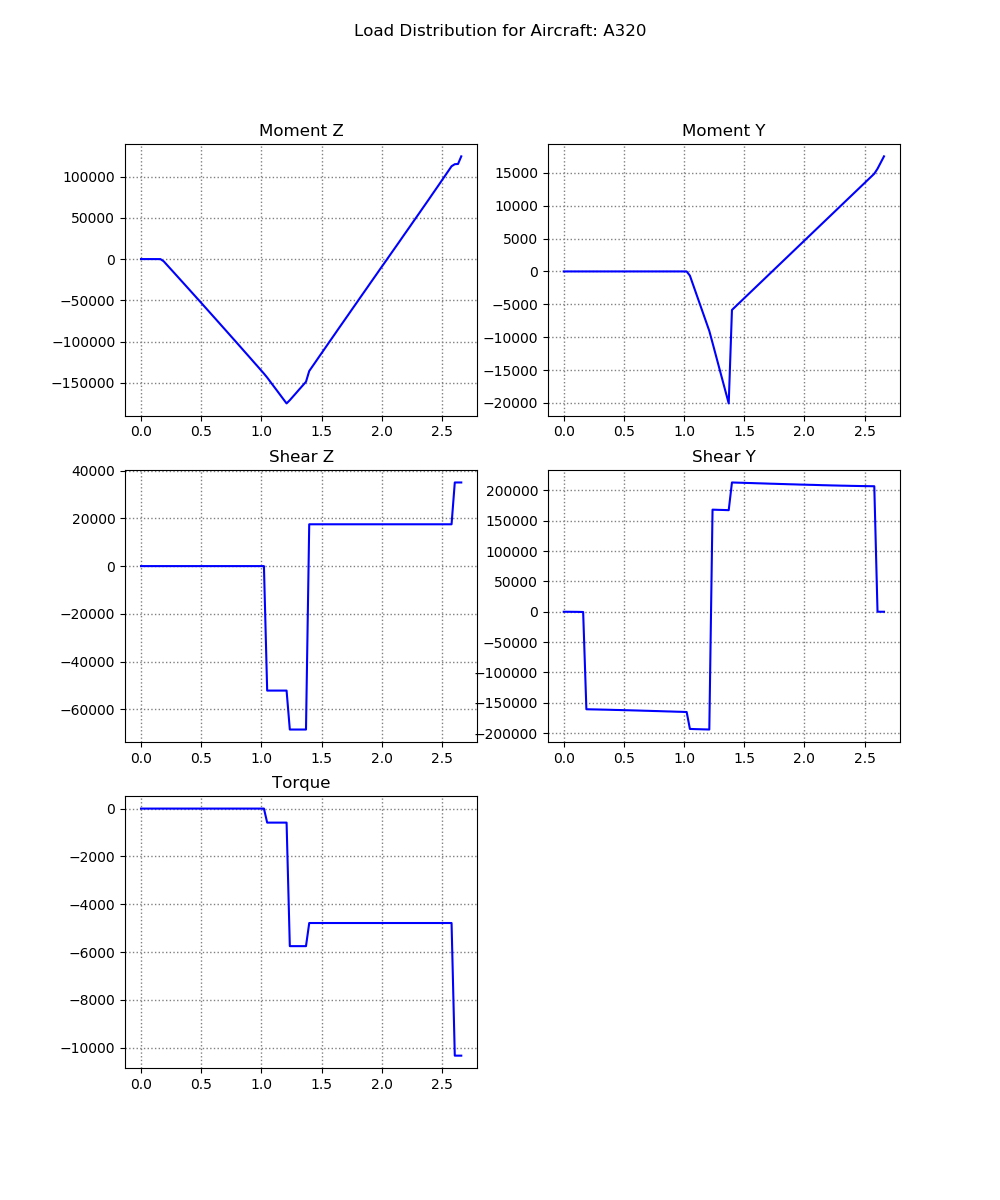

In [216]:
# PLOTTING FORCES ACTING ON AILERON

print("=" * 100)
print(f"Plotting Forces Report for Aircraft: A320")
print("=" * 100, "\n")

# GET FORCE DISTRIBUTION ACCORDING TO STEPS

x_axis = np.linspace(0, l_a, steps)
moment_z = [M_z(x) for x in x_axis]
moment_y = [M_y(x) for x in x_axis]
shear_z = [V_z(x) for x in x_axis]
shear_y = [V_y(x) for x in x_axis]
torque = [T(x) for x in x_axis]

plt.figure(figsize=[10, 12])

plt.suptitle(f"Load Distribution for Aircraft: A320")

plt.subplot(3, 2, 1)
plt.title(f"Moment Z")
plt.plot(x_axis, [M_z(x) for x in x_axis], color='b')
plt.grid()

plt.subplot(3, 2, 2)
plt.title(f"Moment Y")
plt.plot(x_axis, [M_y(x) for x in x_axis], color='b')
plt.grid()

plt.subplot(3, 2, 3)
plt.title(f"Shear Z")
plt.plot(x_axis, [V_z(x) for x in x_axis], color='b')
plt.grid()

plt.subplot(3, 2, 4)
plt.title(f"Shear Y")
plt.plot(x_axis, [V_y(x) for x in x_axis], color='b')
plt.grid()

plt.subplot(3, 2, 5)
plt.title(f"Torque")
plt.plot(x_axis, [T(x) for x in x_axis], color='b')
plt.grid()

plt.show()

## Shear Stress Estimation

In [251]:
def Shear_stress_due_to_shear(qb1,qb2,qb3,qb4,qb5,qb6,t_sk,t_sp):
    
    tau_1 = [qb1[i]/t_sk for i in range(len(qb1))]
    tau_2 = [qb2[i]/t_sp for i in range(len(qb2))]
    tau_3 = [qb3[i]/t_sk for i in range(len(qb3))]
    tau_4 = [qb4[i]/t_sk for i in range(len(qb4))]
    tau_5 = [qb5[i]/t_sp for i in range(len(qb5))]
    tau_6 = [qb6[i]/t_sk for i in range(len(qb6))] 
    
    return tau_1, tau_2, tau_3, tau_4, tau_5, tau_6

def Shear_stress_due_to_torsion(q1,q2,t_sk,t_sp): 
    
    tau_skin_cell_1_lst = [q1[i]/t_sk for i in range(len(q1))]
    tau_skin_cell_2_lst = [q2[i]/t_sk for i in range(len(q1))]
    tau_spar_lst = [(q2[i]-q1[i])/t_sp for i in range(len(q1))]
        
    return tau_skin_cell_1_lst, tau_skin_cell_2_lst, tau_spar_lst


def Twist_of_aileron(T_lst,per_semicircle, per_triangle,t_sk,t_sp,h,l_a,A1,A2):
    
    k = 1/(2*A1) * (per_semicircle/t_sk + 2*h/t_sp) 
    l = 1/(2*A1)*-2*h/t_sp
    m = 1/(2*A2)*-2*h/t_sp
    n = 1/(2*A2) * (per_triangle/t_sk + 2*h/t_sp)
    B = np.array([[2*A1,2*A2,0],[k,l,-1],[m,n,-1]])
    twist_rate_lst = []
    q1_lst = []
    q2_lst = []
    x_theta_0 = l_a/2  #due to assumption around x, x_sc in middle [m]
    theta_0 = -0.00646 #0       #this is a boundary condition [rad]
    for i in range(len(T_lst)):
        w = np.array([T_lst[i],0,0])
        solution = np.linalg.solve(B,w)
        q1 = solution[0]
        q2 = solution[1]
        q1_lst.append(q1)
        q2_lst.append(q2)
        twist_rate_times_G = solution[2]
        twist_rate = twist_rate_times_G / G 
        twist_rate_lst.append(twist_rate)
        
    J = T_lst[-1] / twist_rate_times_G              #calculate the J for a combination of torque and twist rate
    dx = l_a/(len(T_lst)-1)         #step in x direction between the points where the torque is computed and thus where twist_rate is known
    n_steps = math.floor(x_theta_0/dx)      #number of full steps untill location of boundary condition reached, returns an integer
    twist_before_bc = sum([twist_rate_lst[j] for j in range(n_steps)]) * dx + theta_0       #twist of first section
    twist_lst = [twist_before_bc]
    twist_after_bc = theta_0
    
    for i in range(1,len(T_lst)):
        if i < n_steps:
            twist_before_bc = twist_before_bc - twist_rate_lst[i-1]*dx       #compute the twist of each section between two points (positive for positive twist rate)
            twist_lst.append(twist_before_bc)
            
        if i == n_steps:                                  #this is the section where the boundary condition is applied
            twist_lst.append(theta_0)                     #now the section of the boundary condition is reached, this entire section attains this value (neglecting the twist along the even smaller subsection if point of boundary condition falls in between two points)
        if i > n_steps:
            twist_after_bc = twist_after_bc + twist_rate_lst[i]*dx     #or -, plot if torque distribution is known. At the boundary condition, the sign of the twist should change 
            twist_lst.append(twist_after_bc)
            
    return q1_lst,q2_lst, J, twist_rate_lst, twist_lst         #J, twist rate and twist at every x location taken 

def Total_shear_stress(tau_1,tau_2,tau_3,tau_4,tau_5,tau_6, tau_skin_cell_1_lst,tau_skin_cell_2_lst,
                       tau_spar_lst):
    
    total_shear_stress_distribution_at_every_x_loc = []
    
    for j in range(len(tau_skin_cell_1_lst)):
        
        tau_total_1_at_x_loc = [tau_1[i] + tau_skin_cell_1_lst[j] for i in range(len(tau_1))]
        tau_total_2_at_x_loc = [tau_2[i] + tau_spar_lst[j] for i in range(len(tau_2))]
        tau_total_3_at_x_loc = [tau_3[i] + tau_skin_cell_2_lst[j] for i in range(len(tau_3))]
        tau_total_4_at_x_loc = [tau_4[i] + tau_skin_cell_2_lst[j] for i in range(len(tau_4))]
        tau_total_5_at_x_loc = [tau_5[i] + tau_spar_lst[j] for i in range(len(tau_5))]
        tau_total_6_at_x_loc = [tau_6[i] + tau_skin_cell_1_lst[j] for i in range(len(tau_6))]
        
        total_shear_stress_distribution_at_every_x_loc.append(tau_total_1_at_x_loc + tau_total_2_at_x_loc + 
                                                              tau_total_3_at_x_loc + tau_total_4_at_x_loc + 
                                                              tau_total_5_at_x_loc + tau_total_6_at_x_loc)
        
    return total_shear_stress_distribution_at_every_x_loc

def Direct_stress_distribution(Mz,My,Iyy,Izz,zc,yco1,zco1,yco2,zco2,yco3,zco3,yco4,zco4,yco5,zco5,yco6,zco6):     #for a unit moment in x and y direction
    """Computes the Direct stress distrubtion along the cross-section at each point where the shear flow is calculated based on the Mx and My of a specific location along the span"""
    direct_stress_at_every_x_loc = []
    
    for j in range(len(T_lst)):  #or use the variable n
        sigma_xx_1 = [My[j]*abs((zco1[i] - zc))/Iyy - Mz[j]*abs(yco1[i])/Izz for i in range(len(zco1))]            #zc is zlocation of centroid, compute y- and z-location of the middle of each section where the shear flow is computed
        sigma_xx_2 = [My[j]*abs((zco2[i] - zc))/Iyy - Mz[j]*abs(yco2[i])/Izz for i in range(len(zco2))]
        sigma_xx_3 = [My[j]*(zco3[i] - zc)/Iyy - Mz[j]*abs(yco3[i])/Izz for i in range(len(zco3))]
        sigma_xx_4 = [My[j]*(zco4[i]- zc)/Iyy + Mz[j]*abs(yco4[i])/Izz for i in range(len(zco4))]
        sigma_xx_5 = [My[j]*abs((zco5[i] - zc))/Iyy + Mz[j]*abs(yco5[i])/Izz for i in range(len(zco5))]
        sigma_xx_6 = [My[j]*abs((zco6[i] - zc))/Iyy + Mz[j]*abs(yco6[i])/Izz for i in range(len(zco6))]
        
        direct_stress_at_every_x_loc.append(sigma_xx_1 + sigma_xx_2 + sigma_xx_3 + sigma_xx_4 + sigma_xx_5 + sigma_xx_6)       #combine all section to get distribution in one list
    
    return direct_stress_at_every_x_loc

def Von_Mises_stress_distribution(direct_stress_distribution,shear_stress_distribution,n):
    """This function calculates the Von Mises stress distrubtion for every x-location taken along the span, based on the direct stress calculation and the total shear stress calculation"""
    sigma_vm_distribution_at_every_x_loc = []
    
    for j in range(n):
        sigma_vm = [np.sqrt(direct_stress_distribution[j-1][i]**2 + 3*shear_stress_distribution[j-1][i]**2) for i in range(len(direct_stress_distribution[0]))]
        sigma_vm_distribution_at_every_x_loc.append(sigma_vm)
        
    return sigma_vm_distribution_at_every_x_loc  #example sigma_vm_distribution[0] is the distribution at the first x-location taken along the span



In [256]:
ds = 0
segment=[0,1,2]
zco1=[]
yco1=[]

h_seg=0.5*np.pi/((len(segment)*n1)-1)
for segment in segment:
    for i in range(n1):
        b = h_seg * (i + ds)
        zco1.append(-(h-h*np.cos(b)))
        yco1.append(h*np.sin(b))
    ds+=n1

zco6= zco1[::-1]
yco6= [-i for i in yco1[::-1]]

zco2= 2*n1*[-h]
yco2= s_co2
zco5= zco2
yco5= np.linspace(0,-h,2*n1)
zco3= np.linspace(-h,-C_a,7*n1)
yco3= np.linspace(h,0,7*n1)
zco4= zco3[::-1]
yco4= [-i for i in yco3[::-1]]

# GET MOMENTS FROM LOADS DISTRIBUTIONS
T_lst = np.array(torque, dtype=float)  
My_lst = np.array(moment_y, dtype=float)
Mz_lst = np.array(moment_z, dtype=float)

tau_1, tau_2, tau_3, tau_4, tau_5, tau_6 = Shear_stress_due_to_shear(qb1,qb2,qb3,qb4,qb5,qb6,t_sk,t_sp)

q1_lst, q2_lst, J, twist_rate_lst, twist_lst = Twist_of_aileron(T_lst,per_semicircle, per_triangle,t_sk,t_sp,h,l_a,A1,A2)

tau_skin_cell_1_lst, tau_skin_cell_2_lst, tau_spar_lst = Shear_stress_due_to_torsion(q1_lst,q2_lst,t_sk,t_sp)

total_shear_stress_distribution_at_every_x_loc = Total_shear_stress(tau_1,tau_2,tau_3,tau_4,tau_5,tau_6, tau_skin_cell_1_lst,tau_skin_cell_2_lst,tau_spar_lst)

direct_stress_distribution = Direct_stress_distribution(Mz_lst,My_lst,Iyy,Izz,zc,yco1,zco1,yco2,zco2,yco3,zco3,yco4,zco4,yco5,zco5,yco6,zco6)

#Calculation of the Von-Mises stress distribution
#assume tau xy tau xz are neglegible compared to the shear acting in the yz plane, same for sigma_yy and sigma_zz --> calculation of von mises stress simplifies
tau_xy = 0
tau_xz = 0
sigma_yy = 0
sigma_zz = 0

n = len(T_lst)

von_mis = Von_Mises_stress_distribution(direct_stress_distribution,total_shear_stress_distribution_at_every_x_loc,n)


print(f"Torsional Stiffness J: {J}")

Torsional Stiffness J: 6.262167248463587e-05


<IPython.core.display.Javascript object>


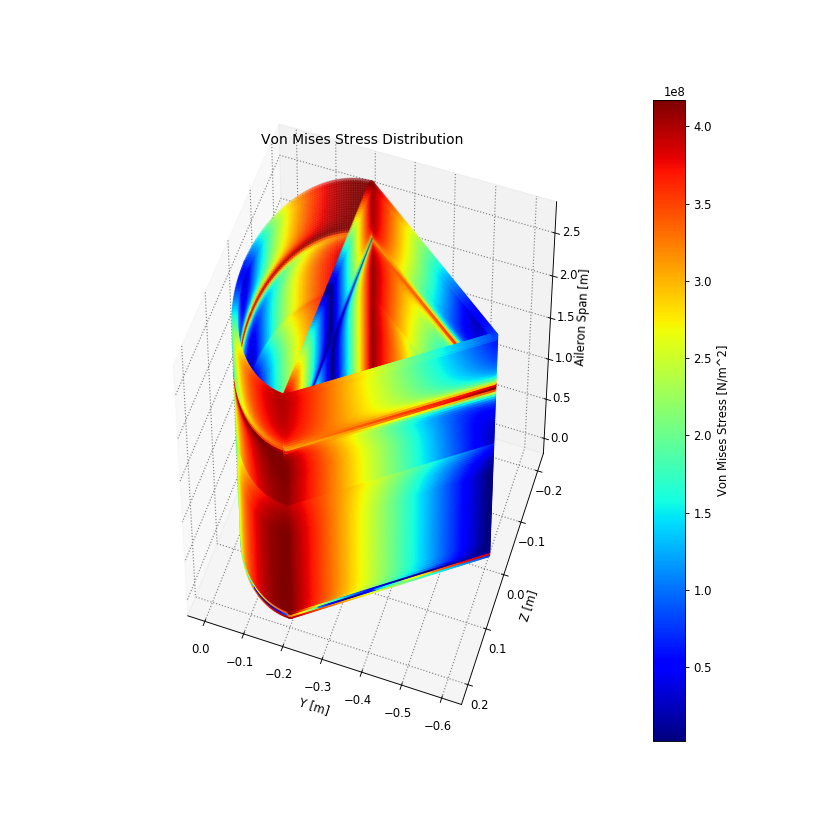

In [257]:
from mpl_toolkits.mplot3d import Axes3D

for i, j in zip([yco2, yco3, yco4, yco5, yco6], [zco2, zco3, zco4, zco5, zco6]):

    yco1.extend(i)
    zco1.extend(j)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')

x_axis = np.linspace(0, l_a, len(von_mis))

for i in range(len(von_mis)):
    p = ax.scatter(zco1, yco1, x_axis[i], c=von_mis[i], cmap='jet')

c = fig.colorbar(p)
c.set_label('Von Mises Stress [N/m^2]')
ax.set_xlabel('Y [m]')
ax.set_ylabel('Z [m]')
ax.set_zlabel('Aileron Span [m]')
plt.title('Von Mises Stress Distribution')

plt.show()

## Twist 

In [220]:
def get_twist(x):
    # input
    twist = 0 # should be c5, but its fucked

    if x > x1:
        twist += 1 / (G * J) * -F_z1 * dsch
    if x > x2:
        twist += 1 / (G * J) * F_z2 * dsch
    if x > x3:
        twist += 1 / (G * J) * -F_z3 * dsch
    if x > xa1:
        twist += 1 / (G * J) * F_a * (np.cos(theta) * dsca_y + np.sin(theta) * dsca_z)
    if x > xa2:
        twist += 1 / (G * J) * -P * (np.cos(theta) * dsca_y + np.sin(theta) * dsca_z)

    return twist

<IPython.core.display.Javascript object>


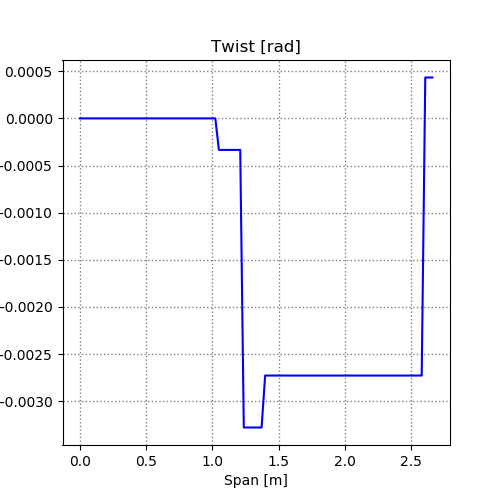

In [221]:
# PLOTTING TWIST

x_location = np.linspace(0, l_a, steps)
tl = [get_twist(i) for i in x_location]

# start plotting figure
plt.figure(figsize=[5, 5])

plt.title(f"Twist [rad]")
plt.plot(x_location, tl, color='b')
plt.grid()
plt.xlabel("Span [m]")
plt.ylabel("Twist [rad]")

plt.show()

## Deflection along span

In [222]:
# DEFINE DEFLECTION AND SLOPE FUNCTIONS ALONG THE SPAN

# temporary fix for the c's that are totally fucked

def Defl_Mz(x):

    # input

    qx = deflection_resultant(x2, discrete_deflections, stepsize) # aero force at la

    v = -1 / E / Izz * (qx) + c1 * x + c2

    if x > x1:
        v -= -1 / E / Izz * (F_y1 / 6 * (x - x1) ** (3))
    if x > x2 - x_a / 2:
        v -= -1 / E / Izz * (F_a * np.sin(theta) / 6 * (x - x2 + x_a / 2) ** (3))
    if x > x2:
        v += -1 / E / Izz * (F_y2 / 6 * (x - x2) ** (3))
    if x > x2 + x_a / 2:
        v += -1 / E / Izz * (P * np.sin(theta) / 6 * (x - x2 - x_a / 2) ** (3))
    if x > x3:
        v -= -1 / E / Izz * (F_y3 / 6 * (x - x3) ** (3))

    return v

def Defl_My(x):
    
    w = c3 * x + c4

    if x > x1:
        w -= -1 / E / Izz * (F_z1 / 6 * (x - x1) ** (3))
    if x > x2 - x_a / 2:
        w -= -1 / E / Izz * (F_a * np.cos(theta) / 6 * (x - x2 + x_a / 2) ** (3))
    if x > x2:
        w -= -1 / E / Izz * (F_z2 / 6 * (x - x2) ** (3))
    if x > x2 + x_a / 2:
        w += -1 / E / Izz * (P * np.cos(theta) / 6 * (x - x2 - x_a / 2) ** (3))
    if x > x3:
        w += -1 / E / Izz * (F_z3 / 6 * (x - x3) ** (3))

    return w


def Slope_y(x):

    qx = angle_resultant(1, discrete_angles, stepsize)

    dvdx = -1 / E / Izz * (qx) + c1

    if x > x1:
        dvdx -= -1 / E / Izz * (F_y1 / 2 * (x - x1) ** (2))

    if x > x2 - x_a / 2:
        dvdx -= -1 / E / Izz * (F_a * np.sin(theta) / 2 * (x - x2 + x_a / 2) ** (2))

    if x > x2:
        dvdx += -1 / E / Izz * (F_y2 / 2 * (x - x2) ** (2))

    if x > x2 + x_a / 2:
        dvdx += -1 / E / Izz * (P * np.sin(theta) / 2 * (x - x2 - x_a / 2) ** (2))

    if x > x3:
        dvdx -= -1 / E / Izz * (F_y3 / 2 * (x - x3) ** (2))

    return dvdx

def Slope_z(x):

    dwdx = c3

    if x > x1:
        dwdx -= -1 / E / Iyy * (F_z1 / 2 * (x - x1) ** (2))

    if x > x2 - x_a / 2:
        dwdx -= -1 / E / Iyy * (F_a * np.cos(theta) / 2 * (x - x2 + x_a / 2) ** (2))

    if x > x2:
        dwdx -= -1 / E / Iyy * (F_z2 / 2 * (x - x2) ** (2))

    if x > x2 + x_a / 2:
        dwdx += -1 / E / Iyy * (P * np.cos(theta) / 2 * (x - x2 - x_a / 2) ** (2))

    if x > x3:
        dwdx += -1 / E / Iyy * (F_z3 / 2 * (x - x3) ** (2))

    return dwdx

getting z slope: 100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33428.74it/s]


<IPython.core.display.Javascript object>


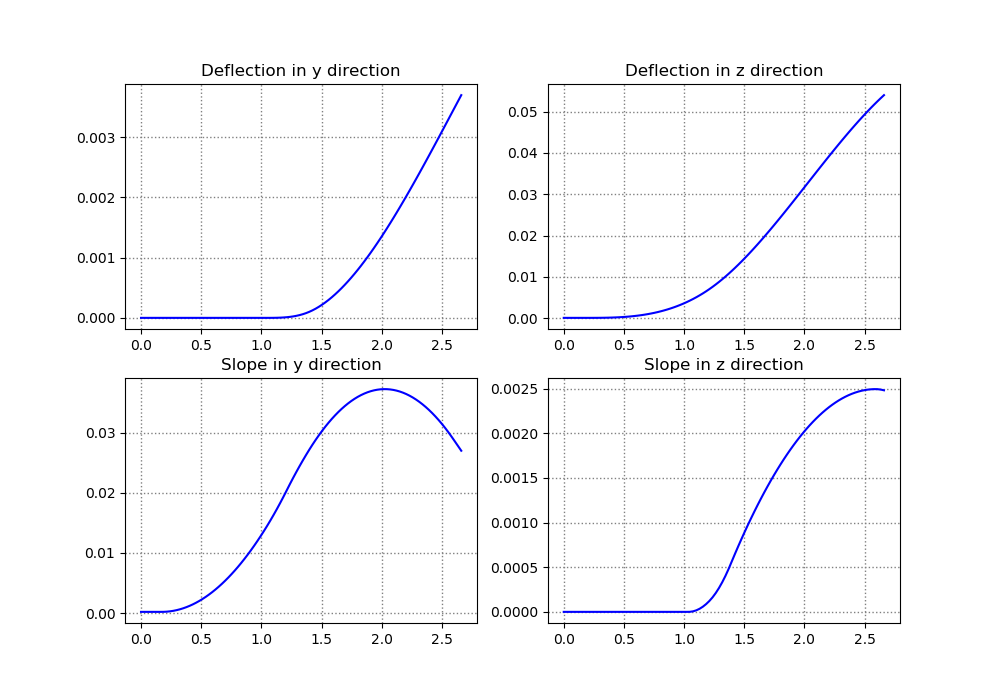

In [223]:
# PLOTTING DEFLECTION

x_axis = np.linspace(0, l_a, steps)
d_y = [float(Defl_My(d)) for d in tqdm(x_axis, desc="getting y deflection")]
d_z = [float(Defl_Mz(d)) for d in tqdm(x_axis, desc="getting z deflection")]
s_y = [float(Slope_y(d)) for d in tqdm(x_axis, desc="getting y slope")]
s_z = [float(Slope_z(d)) for d in tqdm(x_axis, desc="getting z slope")]

plt.figure(figsize=[10, 7])

a = plt.subplot(221)
plt.title(f"Deflection in y direction")
a.plot(x_axis, d_y, color='b')
plt.grid()

b = plt.subplot(222)
plt.title(f"Deflection in z direction")
b.plot(x_axis, d_z, color='b')
plt.grid()

c = plt.subplot(223)
plt.title(f"Slope in y direction")
c.plot(x_axis, s_y, color='b')
plt.grid()

d = plt.subplot(224)
plt.title(f"Slope in z direction")
d.plot(x_axis, s_z, color='b')
plt.grid()

plt.show()

# Verification from model

In [224]:
# VERIFICATION MODEL INPUT
# The plan is to use this input in the script with values from A320 to check the values
# Information wrote from the model will be of length 100

"""Ca = 0.605  # m
    la = 2.661  # m
    x1 = 0.172  # m
    x2 = 1.211  # m
    x3 = 2.591  # m
    xa = 0.35   # m
    ha = 0.205  # m
    tsk = 1.1/1000  # m
    tsp = 2.8/1000  # m
    tst = 1.2/1000  # m
    hst = 16./1000   # m
    wst = 19./1000   # m
    nst = 15  # -
    d1 = 0.01154  # m
    d3 = 0.01840  # m
    theta = m.radians(28)  # rad
    P = 97.4*1000  # N """
    
# build x axis
x_axis = np.linspace(0, l_a, steps)

# open files
path = r"C:\Users\pieca\Desktop\Verification_Model"
str_list = ["defl_1", "defl_2", "defl_3", "slope_1", "slope_2", 
            "slope_3", "shear_y", "shear_z", "moment_y", "moment_z", "torque", "distr_torque"]

all_values = []

for i in range(len(str_list)):
    lst = []
    print(f"extracting ... {str_list[i]}")
    with open(path + str("\\") + str_list[i] + ".txt", 'r+') as f:
        for line in f:
            lst = line.split(",")[:-1]
            lst = [float(i) for i in lst]
            
    all_values.append(lst)
    
print(f"\nCheck correct extraction: {len(all_values)} should be 12")
print(f"Check good length: {len(all_values[0])} should be 100")

extracting ... defl_1
extracting ... defl_2
extracting ... defl_3
extracting ... slope_1
extracting ... slope_2
extracting ... slope_3
extracting ... shear_y
extracting ... shear_z
extracting ... moment_y
extracting ... moment_z
extracting ... torque
extracting ... distr_torque

Check correct extraction: 12 should be 12
Check good length: 100 should be 100


### Make Paired Plotting and Get Results

getting z slope: 100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50159.10it/s]


<IPython.core.display.Javascript object>


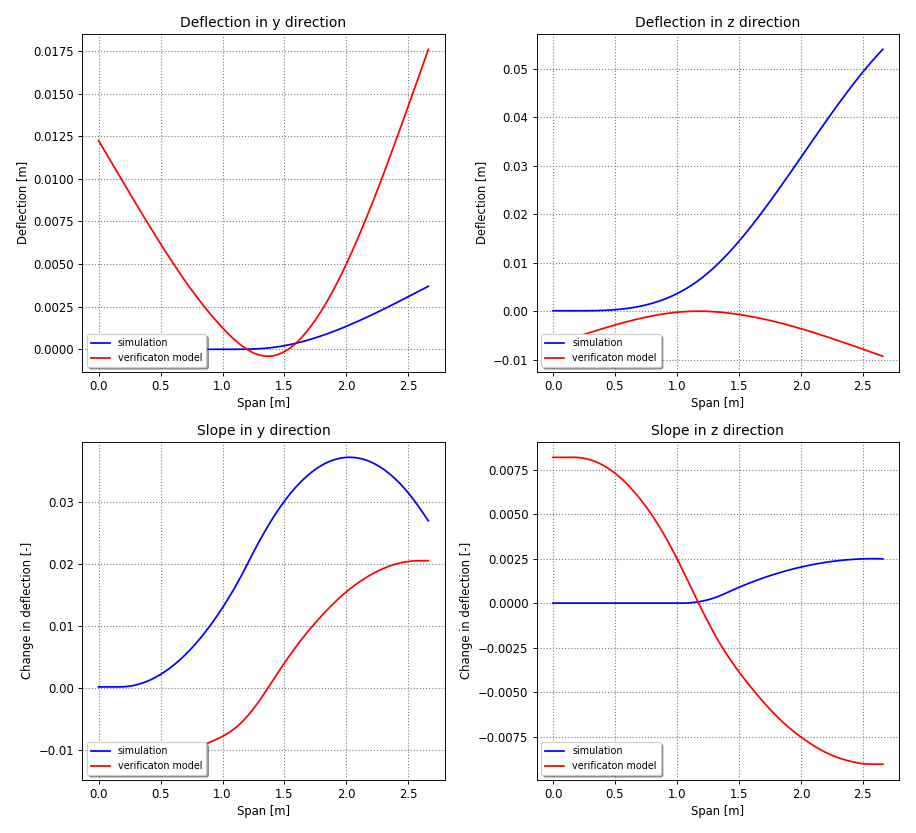

In [249]:
# FULL PLOTTING

# deflection and slope
x_axis = np.linspace(0, l_a, steps)
d_y = [float(Defl_My(d)) for d in tqdm(x_axis, desc="getting y deflection")]
d_z = [float(Defl_Mz(d)) for d in tqdm(x_axis, desc="getting z deflection")]
s_y = [float(Slope_y(d)) for d in tqdm(x_axis, desc="getting y slope")]
s_z = [float(Slope_z(d)) for d in tqdm(x_axis, desc="getting z slope")]
d_y_v = all_values[0]
d_z_v = all_values[1]
s_y_v = all_values[3]
s_z_v = all_values[4]

plt.figure(figsize=[11, 10])

a = plt.subplot(221)
plt.title(f"Deflection in y direction")
a.plot(x_axis, d_y, color='b', label="simulation")
a.plot(x_axis, d_y_v, color='r', label="verificaton model")
plt.xlabel("Span [m]")
plt.ylabel("Deflection [m]")
plt.grid(linestyle='dotted')
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

b = plt.subplot(222)
plt.title(f"Deflection in z direction")
b.plot(x_axis, d_z, color='b', label="simulation")
b.plot(x_axis, d_z_v, color='r',label="verificaton model")
plt.xlabel("Span [m]")
plt.ylabel("Deflection [m]")
plt.grid(linestyle='dotted')
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

c = plt.subplot(223)
plt.title(f"Slope in y direction")
c.plot(x_axis, s_y, color='b', label="simulation")
c.plot(x_axis, s_y_v, color='r', label="verificaton model")
plt.xlabel("Span [m]")
plt.ylabel("Change in deflection [-]")
plt.grid(linestyle='dotted')
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

d = plt.subplot(224)
plt.title(f"Slope in z direction")
d.plot(x_axis, s_z, color='b', label="simulation")
d.plot(x_axis, s_z_v, color='r', label="verificaton model")
plt.xlabel("Span [m]")
plt.ylabel("Change in deflection [-]")
plt.grid(linestyle='dotted')
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.tight_layout(pad=1.5)

plt.show()

<IPython.core.display.Javascript object>


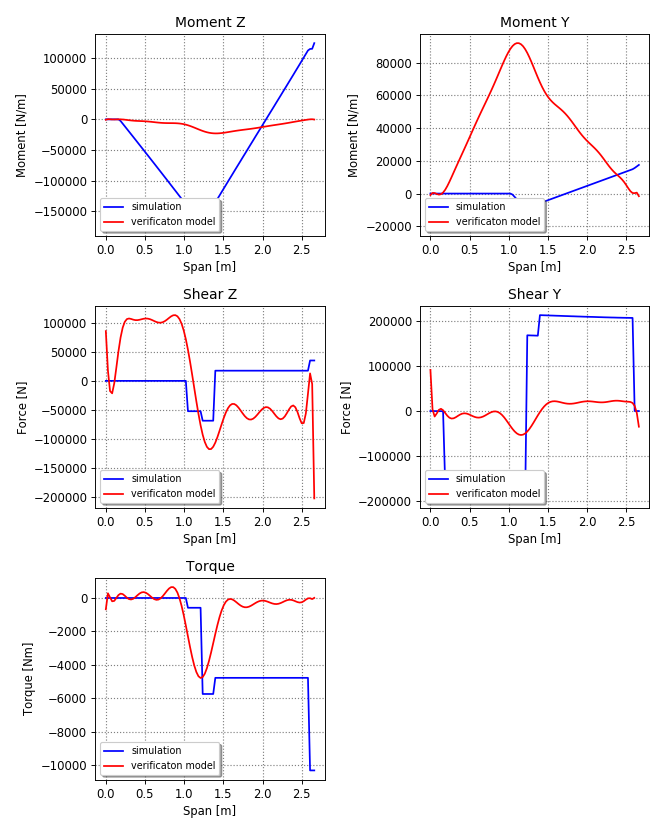

In [248]:
# shear stresses and moments

x_axis = np.linspace(0, l_a, steps)
moment_z = [M_z(x) for x in x_axis]
moment_y = [M_y(x) for x in x_axis]
shear_z = [V_z(x) for x in x_axis]
shear_y = [V_y(x) for x in x_axis]
torque = [T(x) for x in x_axis]
moment_z_v = all_values[9]
moment_y_v = all_values[8]
shear_z_v = all_values[7]
shear_y_v = all_values[6]
torque_v = all_values[10]

plt.figure(figsize=[8, 10])

#plt.suptitle(f"Load Distribution for Aircraft: A320")

plt.subplot(3, 2, 1)
plt.title(f"Moment Z")
plt.plot(x_axis, [M_z(x) for x in x_axis], color='b', label="simulation")
plt.plot(x_axis, moment_z_v, color='r', label="verificaton model")
plt.grid(linestyle='dotted')
plt.xlabel("Span [m]")
plt.ylabel("Moment [N/m]")
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.subplot(3, 2, 2)
plt.title(f"Moment Y")
plt.plot(x_axis, [M_y(x) for x in x_axis], color='b', label="simulation")
plt.plot(x_axis, moment_y_v, color='r', label="verificaton model")
plt.grid(linestyle='dotted')
plt.xlabel("Span [m]")
plt.ylabel("Moment [N/m]")
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.subplot(3, 2, 3)
plt.title(f"Shear Z")
plt.plot(x_axis, [V_z(x) for x in x_axis], color='b', label="simulation")
plt.plot(x_axis, shear_z_v, color='r', label="verificaton model")
plt.grid(linestyle='dotted')
plt.xlabel("Span [m]")
plt.ylabel("Force [N]")
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.subplot(3, 2, 4)
plt.title(f"Shear Y")
plt.plot(x_axis, [V_y(x) for x in x_axis], color='b', label="simulation")
plt.plot(x_axis, shear_y_v, color='r', label="verificaton model")
plt.grid(linestyle='dotted')
plt.xlabel("Span [m]")
plt.ylabel("Force [N]")
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.subplot(3, 2, 5)
plt.title(f"Torque")
plt.plot(x_axis, [T(x) for x in x_axis], color='b', label="simulation")
plt.plot(x_axis, torque_v, color='r', label="verificaton model")
plt.grid(linestyle='dotted')
plt.xlabel("Span [m]")
plt.ylabel("Torque [Nm]")
legend = plt.legend(loc='lower left', shadow=True, fontsize='small')

plt.tight_layout(pad=1.5)

plt.show()